## 📚 Importing Necessary Libraries

To begin, we import all the required libraries and modules for data processing, visualization, and model training:

- **`json`**: For handling JSON files.
- **`random`**: For random sampling.
- **`cv2`**: OpenCV for image processing.
- **`matplotlib.pyplot`**: For visualizing images and plots.
- **`os`**: For file and directory operations.
- **`sklearn.model_selection`**: For splitting data into training, validation, and test sets.
- **`numpy`**: For numerical computations.
- **`torch`**: PyTorch for building and training machine learning models.
- **`torch.nn`**: For defining neural network layers.
- **`torch.utils.data`**: For creating data loaders.
```

In [ ]:
import json
import random
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:

def fix_json_format(file_path):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
            parsed_data = json.loads(content)
        print(f"JSON in '{file_path}' is valid.")
        return parsed_data

    except json.JSONDecodeError as e:
        print(f"JSONDecodeError in '{file_path}': {e}")
        
        error_location = e.pos
        print(f"Error at position: {error_location}")
        
        fixed_content = fix_json(content)
        
        try:
            parsed_data = json.loads(fixed_content)
            with open(file_path, 'w') as file:
                file.write(fixed_content)
            print(f"Fixed and saved JSON in '{file_path}'.")
            return parsed_data
        except json.JSONDecodeError as e:
            print(f"Unable to fix JSON in '{file_path}': {e}")
            return None

def fix_json(content):
    fixed_content = content.replace("], [", "], [")  
    return fixed_content


##main
file_path = 'annotations.json'
data = fix_json_format(file_path)



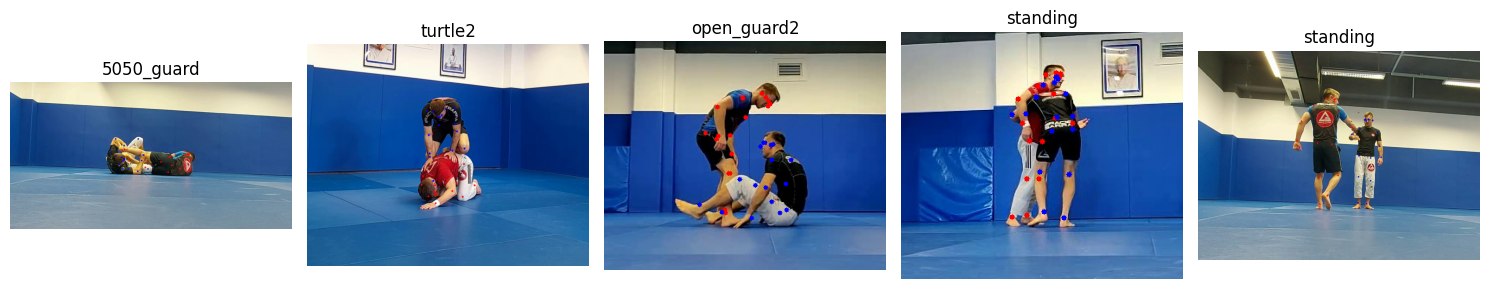

In [ ]:


with open('annotations.json') as f:
    annotations = json.load(f)

valid_annotations = [a for a in annotations if "pose1" in a and "pose2" in a]

image_dir = 'images'

def visualize_pose(image_path, pose1, pose2, title):
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Image not found: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for pose, color in zip([pose1, pose2], ['red', 'blue']):
        if pose:
            for point in pose:
                x, y, c = point
                if c > 0.1:  
                    cv2.circle(
                        image, (int(x), int(y)), 3,
                        (255 if color == 'red' else 0, 0, 255 if color == 'blue' else 0),
                        -1
                    )

    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

num_samples = min(5, len(valid_annotations))

if num_samples == 0:
    print("No valid annotations with both pose1 and pose2.")
else:
    samples = random.sample(valid_annotations, num_samples)

    plt.figure(figsize=(15, 10))
    for i, ann in enumerate(samples):
        img_name = ann.get("image", "unknown") + ".jpg"
        image_path = os.path.join(image_dir, img_name)
        plt.subplot(1, num_samples, i + 1)
        visualize_pose(
            image_path,
            ann.get("pose1"),
            ann.get("pose2"),
            ann.get("position", "Unknown")
        )

    plt.tight_layout()
    plt.show()


In [ ]:

train_anns, temp_anns = train_test_split(valid_annotations, test_size=0.3, random_state=42)

val_anns, test_anns = train_test_split(temp_anns, test_size=0.5, random_state=42)

print(f"Train: {len(train_anns)}, Val: {len(val_anns)}, Test: {len(test_anns)}")



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Train: 53440, Val: 11451, Test: 11452


In [ ]:

positions = list(set(a["position"] for a in valid_annotations))
position_to_id = {pos: i for i, pos in enumerate(positions)}

def encode_pose(pose):
    return [coord for keypoint in pose for coord in keypoint]  

def prepare_data(annotations):
    X = []
    y = []
    for ann in annotations:
        pose1 = encode_pose(ann["pose1"])
        pose2 = encode_pose(ann["pose2"])
        X.append(pose1 + pose2)  
        y.append(position_to_id[ann["position"]])
    return np.array(X, dtype=np.float32), np.array(y)

X_train, y_train = prepare_data(train_anns)
X_val, y_val = prepare_data(val_anns)
X_test, y_test = prepare_data(test_anns)


In [ ]:


class SimplePoseClassifier(nn.Module):
    def __init__(self, input_dim=102, num_classes=len(position_to_id), hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=32)

model = SimplePoseClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).long()
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            pred_labels = preds.argmax(dim=1)
            correct += (pred_labels == yb).sum().item()
            total += yb.size(0)

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Val Acc: {correct/total:.2f}")




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Epoch 1, Loss: 1852.2920, Val Acc: 0.80
Epoch 2, Loss: 726.4375, Val Acc: 0.89
Epoch 3, Loss: 597.2327, Val Acc: 0.88
Epoch 4, Loss: 533.5075, Val Acc: 0.91
Epoch 5, Loss: 512.3499, Val Acc: 0.93
Epoch 6, Loss: 427.6424, Val Acc: 0.92
Epoch 7, Loss: 408.2801, Val Acc: 0.90
Epoch 8, Loss: 406.8176, Val Acc: 0.94
Epoch 9, Loss: 356.0183, Val Acc: 0.95
Epoch 10, Loss: 335.0744, Val Acc: 0.94


In [7]:
test_loader = DataLoader(TensorDataset(torch.tensor(X_test)), batch_size=1)
model.eval()

inv_position_map = {v: k for k, v in position_to_id.items()}

predictions = []
with torch.no_grad():
    for xb in test_loader:
        xb = xb[0].to(device)
        pred = model(xb)
        label = pred.argmax(dim=1).item()
        predictions.append(inv_position_map[label])


## 🔍 Visualizing Pose Prediction Results

The `visualize_predictions` function helps evaluate the model's performance by visualizing predictions on a set of pose samples.

---

### 📥 Inputs

- **`samples`**: A list of dictionaries, where each dictionary contains:
  - `pose1` and `pose2`: The two poses to be encoded and fed to the model.
  - `position`: The ground truth label (class).
  - `image`: The filename (without extension) of the image to visualize.

- **`model`**: A trained PyTorch model that predicts the relative position between two poses.

- **`device`**: The computation device, either `'cpu'` or `'cuda'`.

- **`position_to_id`**: A dictionary mapping position labels (strings) to numeric class indices.

- **`image_dir`**: Path to the directory containing the image files (e.g., `images/`).

---

### ⚙️ Process

1. Puts the model in **evaluation mode** (`model.eval()`).
2. Iterates through each sample in `samples`.
3. Encodes `pose1` and `pose2` using `encode_pose()` and creates an input tensor.
4. Feeds the tensor into the model to get the prediction.
5. Decodes the predicted label using `inv_position_map`.
6. Displays the original image with poses and shows both **Ground Truth (GT)** and **Predicted** labels using `visualize_pose()`.

---

### 📤 Output

A side-by-side **matplotlib visualization** of all the given samples, each showing:
- The input image.
- The overlaid poses.
- The ground truth label.
- The predicted label from the model.



In [ ]:

def visualize_predictions(samples, model, device, position_to_id, image_dir):
    model.eval()
    inv_position_map = {v: k for k, v in position_to_id.items()}

    plt.figure(figsize=(18, 6))
    for i, ann in enumerate(samples):
        pose1 = ann["pose1"]
        pose2 = ann["pose2"]
        img_name = ann["image"] + ".jpg"
        image_path = os.path.join(image_dir, img_name)

        input_vec = encode_pose(pose1) + encode_pose(pose2)
        input_tensor = torch.tensor(input_vec, dtype=torch.float32).unsqueeze(0).to(device)
        pred = model(input_tensor)
        pred_label = pred.argmax(dim=1).item()

        gt_label = ann["position"]
        pred_label_name = inv_position_map[pred_label]

        title = f"GT: {gt_label}\nPred: {pred_label_name}"

        plt.subplot(1, len(samples), i + 1)
        visualize_pose(image_path, pose1, pose2, title)

    plt.tight_layout()
    plt.show()


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=32)

def compute_test_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total if total > 0 else 0.0

test_acc = compute_test_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
##

Test Accuracy: 93.36%


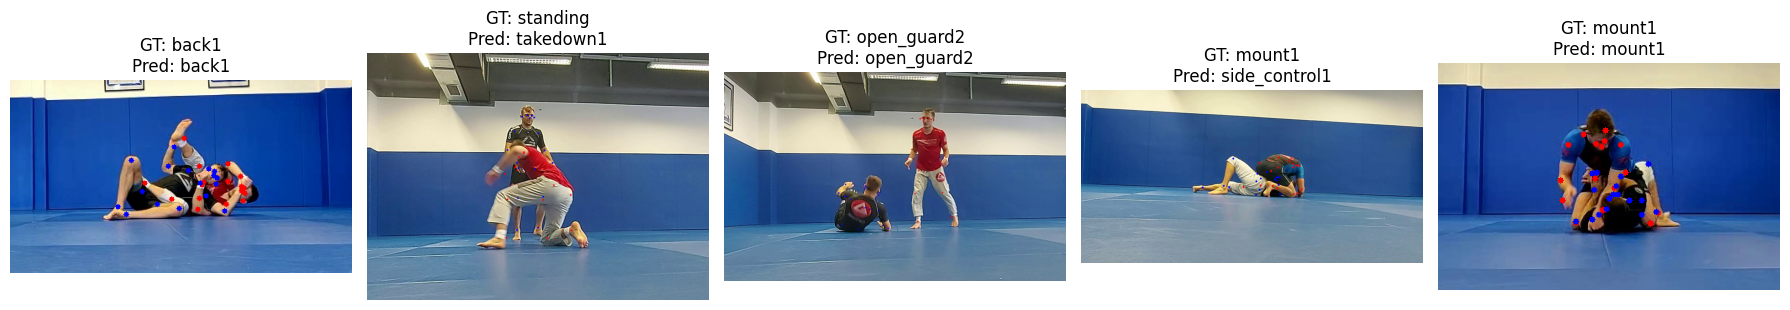

In [10]:
num_samples = 5
test_samples = random.sample(test_anns, min(num_samples, len(test_anns)))

visualize_predictions(test_samples, model, device, position_to_id, image_dir)
